In [ ]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

# enter the foldername in your Drive where you have saved the unzipped
# 'cs231n' folder containing the '.py', 'classifiers' and 'datasets'
# folders.
# e.g. 'cs231n/assignments/assignment1/cs231n/'
FOLDERNAME = None

assert FOLDERNAME is not None, "[!] Enter the foldername."

%cd /content/drive/My\ Drive
%cp -r $FOLDERNAME ../../
%cd ../../
%cd cs231n/datasets/
!bash get_datasets.sh
%cd ../../

In [1]:
# If not on Google Colab

%cd cs231n/datasets/
!bash get_datasets.sh
%cd ../..

/Users/leourbina/Google Drive/Courses/cs231n/assignment1/cs231n/datasets
--2020-05-11 22:37:35--  http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  23.5MB/s    in 7.5s    

2020-05-11 22:37:43 (21.6 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]

x cifar-10-batches-py/
x cifar-10-batches-py/data_batch_4
x cifar-10-batches-py/readme.html
x cifar-10-batches-py/test_batch
x cifar-10-batches-py/data_batch_3
x cifar-10-batches-py/batches.meta
x cifar-10-batches-py/data_batch_2
x cifar-10-batches-py/data_batch_5
x cifar-10-batches-py/data_batch_1
/Users/leourbina/Google Drive/Courses/cs231n/assignment1


# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [163]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 10.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    
    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside `cs231n/classifiers/softmax.py`.

Softmax loss is

$$ L_i = - \log\left(\frac{e^{f_{y_i}}}{\sum_j e^{f_j}}\right) $$

$$ L = - \frac{1}{N}\sum_i^N \log\left(\frac{e^{f_{y_i}}}{\sum_j e^{f_j}}\right) $$

Partial derivatives are given by: 

$$\frac{ \partial L_i }{\partial w_j } 
= \frac{ \partial L_i }{ \partial f_j } \frac{\partial f_j}{ \partial w_j } $$

$$ \frac{ \partial L_i }{ \partial f_j } 
= \left\{
    \begin{array}\\
        \frac{e^{f_{y_i}}}{\sum_k e^{f_k}} - 1 & \mbox{if } \ j = y_i \\
        \frac{e^{f_j}}{\sum_k e^{f_k}} & \mbox{if } \ j \neq y_i 
    \end{array}
\right.
$$

$$
f_i = x^T w_i
$$

$$ 
\frac{\partial f_i}{ \partial w_j } 
= \left\{
    \begin{array}\\
        x^T & \mbox{if } \ j = i \\
        0 & \mbox{if } \ j \neq i
    \end{array}
\right.
$$

# Example 1 of backprop

$$f(x, y, z) = (x + y)z $$


In [7]:
x = -2; y = 5; z = -4

q = x + y
f = q*z
f

-12

In [8]:
# set some inputs
x = -2; y = 5; z = -4

# perform the forward pass
q = x + y # q becomes 3
f = q * z # f becomes -12

# perform the backward pass (backpropagation) in reverse order:
# first backprop through f = q * z
dfdz = q # df/dz = q, so gradient on z becomes 3
dfdq = z # df/dq = z, so gradient on q becomes -4
# now backprop through q = x + y
dfdx = 1.0 * dfdq # dq/dx = 1. And the multiplication here is the chain rule!
dfdy = 1.0 * dfdq # dq/dy = 1

[dfdx, dfdy, dfdz]

[-4.0, -4.0, 3]

In [9]:
dfdz = q 
dfdq = z 
dqdx = 1.0
dqdy = 1.0

dfdx = dfdq * dqdx
dfdy = dfdq * dqdy

[dfdx, dfdy, dfdz]

[-4.0, -4.0, 3]

## Sigmoid example

$$ f(w,x) = \frac{1}{1 + e^{-(w_0x_0 + w_1x_1 + w_2)}} $$

In [59]:
w0 = 2; x0 = -1; w1 = -3; x1 = -2; w2 = -3;

w = np.array([[2, -3, -3], [1, 2, 3], [5, 6, 7]], dtype='float64')
x = np.array([-1, -2, 1])

def sigmoid(x):
  return 1.0 / (1 + np.exp(-x))


def f(x, w):
  dot = w.dot(x)
  f = sigmoid(dot)
  
  ddot = f * (1-f)
  dw = ddot[:, np.newaxis] * x 

  return f, dw

In [61]:
def eval_numerical_gradient(f, x, h=0.01):
  it = np.nditer(x, flags=['multi_index'])
  grad = np.zeros(x.shape)

  while not it.finished:
    ix = it.multi_index
    oldval = x[ix]
    x[ix] = oldval + h
    fxph = f(x)
    x[ix] = oldval - h
    fxmh = f(x)
    x[ix] = oldval
    grad[ix] = np.sum(fxph - fxmh)/(2.0 * h)
    it.iternext()
    
  return grad

In [65]:
eval_numerical_gradient(lambda ww: f(x, ww)[0], w, h=1e-10)

array([[-1.96611616e-01, -3.93223232e-01,  1.96611616e-01],
       [-1.04993583e-01, -2.09987097e-01,  1.04993583e-01],
       [-4.53966292e-05, -9.07915981e-05,  4.53958160e-05]])

In [64]:
f(x, w)[1]

array([[-1.96611933e-01, -3.93223866e-01,  1.96611933e-01],
       [-1.04993585e-01, -2.09987171e-01,  1.04993585e-01],
       [-4.53958077e-05, -9.07916155e-05,  4.53958077e-05]])

In [96]:
it.finished

False

In [68]:
w0 = 2; x0 = -1; w1 = -3; x1 = -2; w2 = -3;

w = np.array([[2, -3, -3]])
x = np.array([-1, -2, 1])

def sigmoid(x):
  return 1.0 / (1 + np.exp(-x))

dot = w.dot(x)
f = sigmoid(dot)
f

ddot = f * (1-f)
dw = ddot * x 
dx = ddot * w

dw

array([-0.19661193, -0.39322387,  0.19661193])

In [39]:
import math
w = [2,-3,-3] # assume some random weights and data
x = [-1, -2]

# forward pass
dot = w[0]*x[0] + w[1]*x[1] + w[2]
f = 1.0 / (1 + math.exp(-dot)) # sigmoid function

# backward pass through the neuron (backpropagation)
ddot = (1 - f) * f # gradient on dot variable, using the sigmoid gradient derivation
dx = [w[0] * ddot, w[1] * ddot] # backprop into x
dw = [x[0] * ddot, x[1] * ddot, 1.0 * ddot] # backprop into w
# we're done! we have the gradients on the inputs to the circuit

dw, dx

([-0.19661193324148185, -0.3932238664829637, 0.19661193324148185],
 [0.3932238664829637, -0.5898357997244456])

# Softmax Example



In [74]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, _ = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.349928
sanity check: 2.302585


**Inline Question 1**

Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

$\color{blue}{\textit Your Answer:}$ *Fill this in* 

In [128]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 0.987442 analytic: 0.987442, relative error: 1.751172e-08
numerical: 1.820126 analytic: 1.820125, relative error: 5.088550e-08
numerical: 0.056345 analytic: 0.056345, relative error: 1.221403e-06
numerical: -0.255119 analytic: -0.255119, relative error: 1.101781e-08
numerical: 1.377432 analytic: 1.377432, relative error: 1.017256e-08
numerical: -0.650700 analytic: -0.650700, relative error: 6.323613e-08
numerical: -0.874497 analytic: -0.874497, relative error: 1.654636e-08
numerical: 0.614396 analytic: 0.614396, relative error: 2.422419e-08
numerical: 0.169760 analytic: 0.169760, relative error: 4.151505e-08
numerical: -0.749271 analytic: -0.749271, relative error: 4.280566e-08
numerical: 5.279272 analytic: 5.278002, relative error: 1.202564e-04
numerical: 1.574041 analytic: 1.576868, relative error: 8.971450e-04
numerical: -3.330822 analytic: -3.327029, relative error: 5.696935e-04
numerical: -2.032972 analytic: -2.029170, relative error: 9.359378e-04
numerical: 0.733629 an

In [138]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.349928e+00 computed in 0.081365s
(500, 3073) (500, 10)
vectorized loss: 2.349928e+00 computed in 0.003005s
Loss difference: 0.000000
Gradient difference: 0.000000


In [142]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.

from cs231n.classifiers import Softmax
from uuid import uuid4

run_id = uuid4()
all_results = { run_id: {}}
best_val = -1
best_softmax = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################

# Provided as a reference. You may or may not want to change these hyperparameters

total = 20
learning_rates = [10**-7*(1 + np.random.rand()) for x in range(total)] # randomly search between 1e-7 and 1e-8
regularization_strengths = [6000*(1 + np.random.rand()) for x in range(total)] # Randomly sample between 6000 and 12,000 in log scale
accuracies = []

# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

def accuracy(model, X, y):
  y_pred = model.predict(X)
  return np.mean(y_pred == y)  

i = 0

for lr, reg in zip(learning_rates, regularization_strengths):
  i += 1 
  model = Softmax()
  model.train(X_train, y_train, learning_rate=lr, reg=reg, num_iters=5000, verbose=False)
      
  train_acc = accuracy(model, X_train, y_train)
  val_acc = accuracy(model, X_val, y_val)
    
  accuracies.append(val_acc)
    
  print(f"{i}/{total} [lr: {lr} reg: {reg:.3f} train: {train_acc:.3f} val: {val_acc:.3f}]")
  all_results[run_id][(lr, reg)] = (train_acc, val_acc)
    
  if val_acc > best_val:
    best_val = val_acc
    best_softmax = model

    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

1/20 [lr: 1.217652137457801e-07 reg: 7271.461 train: 0.385 val: 0.397]
2/20 [lr: 1.2257995453964355e-07 reg: 6214.991 train: 0.384 val: 0.398]
3/20 [lr: 1.5719597411299018e-07 reg: 10683.145 train: 0.373 val: 0.390]
4/20 [lr: 1.6777366928240406e-07 reg: 7824.280 train: 0.380 val: 0.401]
5/20 [lr: 1.363101800602941e-07 reg: 6229.479 train: 0.387 val: 0.393]
6/20 [lr: 1.089994350755147e-07 reg: 6939.485 train: 0.382 val: 0.393]
7/20 [lr: 1.50854313166975e-07 reg: 10747.991 train: 0.371 val: 0.385]
8/20 [lr: 1.6317440189522889e-07 reg: 10307.420 train: 0.371 val: 0.386]
9/20 [lr: 1.4638822039692727e-07 reg: 9447.055 train: 0.378 val: 0.386]
10/20 [lr: 1.352251902447436e-07 reg: 6741.420 train: 0.384 val: 0.394]
11/20 [lr: 1.9039702367278584e-07 reg: 11178.880 train: 0.369 val: 0.383]
12/20 [lr: 1.333636245562519e-07 reg: 7129.908 train: 0.384 val: 0.399]
13/20 [lr: 1.8417589445552871e-07 reg: 6135.465 train: 0.385 val: 0.401]
14/20 [lr: 1.304739251933327e-07 reg: 7625.791 train: 0.382 val

In [147]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.379000


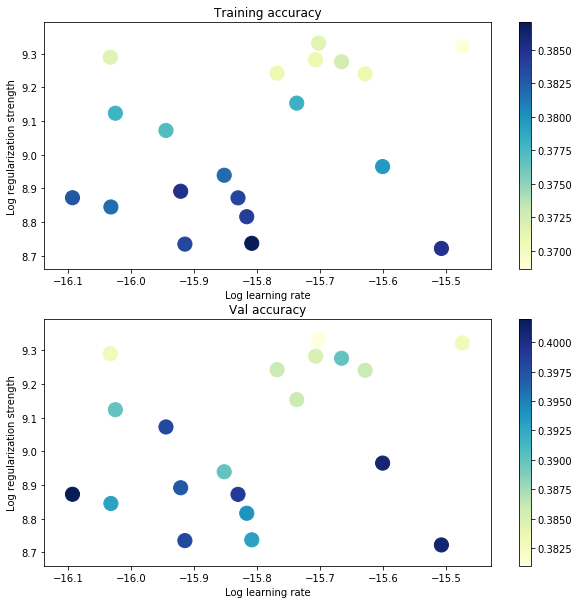

In [164]:
import math

xs = [math.log(x) for x in learning_rates]
ys = [math.log(x) for x in regularization_strengths]

mark_size = 200

colors_train = [all_results[run_id][(x, y)][0] for x, y in zip(learning_rates, regularization_strengths)]
plt.subplot(2, 1, 1)
plt.scatter(xs, ys, mark_size, c=colors_train, cmap=plt.cm.YlGnBu)
plt.title('Training accuracy')
plt.xlabel('Log learning rate')
plt.ylabel('Log regularization strength')
plt.colorbar()

colors_val = [all_results[run_id][(x, y)][1] for x, y in zip(learning_rates, regularization_strengths)]
plt.subplot(2, 1, 2)
plt.title('Val accuracy')
plt.xlabel('Log learning rate')
plt.ylabel('Log regularization strength')
plt.scatter(xs, ys, mark_size, c=colors_val, cmap=plt.cm.YlGnBu)
plt.colorbar()



**Inline Question 2** - *True or False*

Suppose the overall training loss is defined as the sum of the per-datapoint loss over all training examples. It is possible to add a new datapoint to a training set that would leave the SVM loss unchanged, but this is not the case with the Softmax classifier loss.

$\color{blue}{\textit Your Answer:}$

The per datapoint loss for SVM is defined as:

$$L_i = \sum_{j \in C}max(s_j - s_{y_i} + \Delta, 0)$$

The intuition here is that the SVM is forcing a marging of at least $\Delta$ in the 'gap' between classes. It is possible to add a datapoint to the training set that does not affect this margin as it's score for every incorrect class is very small, and therefore it's total contribution to the loss is 0.

In contrast the per datapoint loss for Softmax is defined as:

$$L_i = -\log\left(\frac{e^{f_{y_i}}}{\sum_{j \in C} e^{f_j}}\right) $$

The argument of the log $p_i$ is in $(0, 1)$ as $e^x > 0\: \forall x\in {\rm I\!R}$, thus $-\log(p_i) \in (0, \infty)$. Therefore it is not possible to add a training datapoint without modifying the loss.



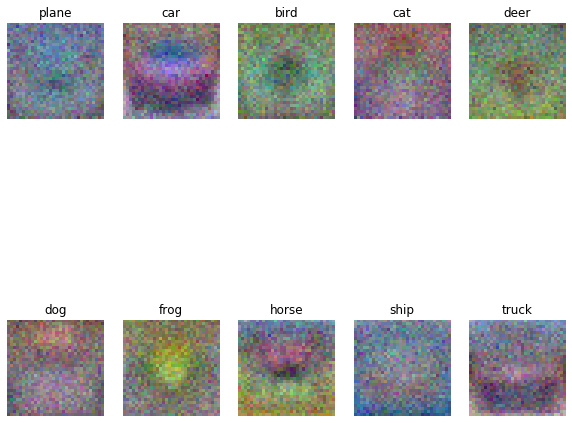

In [165]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)

    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

---
# IMPORTANT

This is the end of this question. Please do the following:

1. Click `File -> Save` to make sure the latest checkpoint of this notebook is saved to your Drive.
2. Execute the cell below to download the modified `.py` files back to your drive.

In [ ]:
import os

FOLDER_TO_SAVE = os.path.join('drive/My Drive/', FOLDERNAME)
FILES_TO_SAVE = ['cs231n/classifiers/softmax.py']

for files in FILES_TO_SAVE:
  with open(os.path.join(FOLDER_TO_SAVE, '/'.join(files.split('/')[1:])), 'w') as f:
    f.write(''.join(open(files).readlines()))